# RNN with torch

# Load Data
task in here is to predict the next token based on current sequential text data (numbers now)

In our dataset, we dont have tokens, we just have letters and correspoding letter vocab

In [1]:
# 导入 PyTorch 库
import torch
# 导入 nn 模块，用于定义神经网络模型的基类
from torch import nn
# 导入 functional 模块，用于定义神经网络模型中的激活函数等功能
from torch.nn import functional as F
# 导入 d2l.torch 模块，包含了与深度学习相关的工具函数和类
from d2l import torch as d2l

In [2]:
# 设置批量大小和时间步数, 时间步长在这里是？
batch_size, num_steps = 32, 35
# 调用 load_data_time_machine 函数加载时间机器数据集，返回训练数据迭代器和词汇表
# this is the fucntion from seq_model_text_data.ipynb
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [3]:
for batch_data, batch_label in train_iter:
    print(batch_data.shape, batch_label.shape)
    for i in range(batch_data.shape[0]):
        print(batch_data[i], batch_label[i])
        print(batch_data[i+1], batch_label[i+1]) # note that data in same batch is individual, the item in each row is sequential.
        break
    break

torch.Size([32, 35]) torch.Size([32, 35])
tensor([18,  1, 17,  2, 12, 12,  8,  5,  3,  9,  2,  1,  3,  5, 13,  2,  1,  3,
        10,  4, 22,  2, 12, 12,  2, 10,  1, 16,  7, 10,  1,  8,  7,  1,  5]) tensor([ 1, 17,  2, 12, 12,  8,  5,  3,  9,  2,  1,  3,  5, 13,  2,  1,  3, 10,
         4, 22,  2, 12, 12,  2, 10,  1, 16,  7, 10,  1,  8,  7,  1,  5,  3])
tensor([ 4,  3,  1, 16, 12,  4,  8,  9,  2, 11,  1,  4,  6, 11, 20,  4,  8,  8,
         2, 11,  1,  5,  6,  1,  7, 14, 10,  1, 18, 12,  4,  8,  8,  2,  8]) tensor([ 3,  1, 16, 12,  4,  8,  9,  2, 11,  1,  4,  6, 11, 20,  4,  8,  8,  2,
        11,  1,  5,  6,  1,  7, 14, 10,  1, 18, 12,  4,  8,  8,  2,  8,  1])


In [4]:
vocab.__len__(), vocab.token_freqs[:5]

(28, [(' ', 29927), ('e', 17838), ('t', 13515), ('a', 11704), ('i', 10138)])

In [11]:
for batch_data, batch_label in train_iter:
    for i in range(batch_data.shape[0]):
        print(batch_data[i][:10], batch_label[i][:10])
        for j in range(10):
            token = vocab.idx_to_token[batch_data[i][j].item()]
            label = vocab.idx_to_token[batch_label[i][j].item()]
            print(token, label)
        break
    break

tensor([18,  1, 17,  2, 12, 12,  8,  5,  3,  9]) tensor([ 1, 17,  2, 12, 12,  8,  5,  3,  9,  2])
g  
  w
w e
e l
l l
l s
s i
i t
t h
h e


# RNN Layer demo

In [9]:
# 定义模型
# 设置隐藏单元的数量为 256
num_hiddens = 256
# 使用 nn.RNN 类定义一个循环神经网络层
# 输入大小为词汇表的大小，隐藏单元数量为 num_hiddens
# 将该循环神经网络层赋值给 rnn_layer
rnn_layer = nn.RNN(
    input_size=len(vocab), 
    hidden_size=num_hiddens,
    num_layers=1
    )

In [14]:
# 使用张量来初始化隐藏状态
# 创建一个形状为 (1, batch_size, num_hiddens) 的张量，用于初始化隐藏状态
# 全部元素初始化为 0
# 将该张量赋值给变量 state

# [num_layers, batch_size, hidden_size] for h0
state = torch.zeros([1, batch_size, num_hiddens])

# # 打印隐藏状态张量的形状
# state.shape

# 通过一个隐藏状态和一个输入，我们可以用更新后的隐藏状态计算输出
# 创建一个形状为 (num_steps, batch_size, len(vocab)) 的随机张量 X
# 用于表示输入的序列，每个时间步的输入为一个词汇表大小的独热编码向量
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
X

tensor([[[0.3560, 0.6172, 0.5150,  ..., 0.8039, 0.1317, 0.5847],
         [0.0790, 0.7782, 0.2531,  ..., 0.4337, 0.7142, 0.6340],
         [0.8501, 0.2323, 0.9214,  ..., 0.1006, 0.8546, 0.7437],
         ...,
         [0.6204, 0.5130, 0.6020,  ..., 0.3956, 0.2403, 0.0444],
         [0.5790, 0.7035, 0.7445,  ..., 0.1108, 0.7971, 0.1969],
         [0.7191, 0.1199, 0.7444,  ..., 0.0422, 0.5180, 0.2061]],

        [[0.9269, 0.7026, 0.7880,  ..., 0.4834, 0.6210, 0.4026],
         [0.6148, 0.0557, 0.7053,  ..., 0.4759, 0.0469, 0.6945],
         [0.2728, 0.6167, 0.5923,  ..., 0.0845, 0.5843, 0.7949],
         ...,
         [0.3293, 0.9562, 0.7940,  ..., 0.9205, 0.5788, 0.3330],
         [0.6356, 0.7523, 0.3352,  ..., 0.9047, 0.5745, 0.2749],
         [0.0059, 0.6487, 0.1622,  ..., 0.2954, 0.8275, 0.7248]],

        [[0.5244, 0.9955, 0.0454,  ..., 0.0668, 0.9591, 0.1084],
         [0.7553, 0.8987, 0.6367,  ..., 0.3083, 0.2313, 0.1387],
         [0.7235, 0.5129, 0.7736,  ..., 0.3533, 0.2583, 0.

In [15]:
# 将输入 X 和初始隐藏状态 state 作为输入传递给循环神经网络层 rnn_layer 进行前向计算
# 返回输出张量 Y 和更新后的隐藏状态 state_new
_X, state_new = rnn_layer(X, state)
_X

tensor([[[ 5.3956e-02,  6.7392e-02,  8.5952e-02,  ...,  9.8408e-02,
           6.6859e-02, -1.2037e-01],
         [ 6.7961e-02,  1.5696e-01, -1.3764e-02,  ...,  5.3882e-02,
           1.7314e-01, -1.3097e-01],
         [ 8.9147e-03,  2.3577e-01,  7.2885e-02,  ...,  1.9863e-01,
           2.3703e-01, -3.2775e-02],
         ...,
         [-4.8886e-02,  1.8803e-01,  1.0133e-01,  ...,  1.0486e-01,
           1.1634e-01, -1.5765e-01],
         [ 1.8531e-02,  1.6868e-01,  1.3301e-01,  ...,  6.3184e-02,
           1.0289e-01, -7.9634e-02],
         [ 5.1430e-03,  8.6579e-02,  8.4219e-02,  ...,  1.7012e-01,
           2.1480e-01, -1.4556e-01]],

        [[ 6.0694e-02,  2.7021e-01,  1.3798e-01,  ...,  6.2165e-02,
           1.6008e-01, -8.9307e-02],
         [ 1.3615e-01,  2.1184e-01,  1.3890e-01,  ...,  1.5215e-02,
           2.0610e-01, -9.8720e-02],
         [ 3.8677e-02,  2.4548e-01,  5.2717e-02,  ...,  7.5380e-02,
           2.0263e-01, -1.5121e-01],
         ...,
         [ 3.5803e-02,  2

In [16]:
# 打印输出张量 Y 和更新后的隐藏状态 state_new 的形状
X.shape, state.shape, _X.shape, state_new.shape

(torch.Size([35, 32, 28]),
 torch.Size([1, 32, 256]),
 torch.Size([35, 32, 256]),
 torch.Size([1, 32, 256]))

# RNN Model Class

In [8]:
# 我们为一个完整的循环神经网络模型定义一个RNNModel类
class RNNModel(nn.Module):
    """循环神经网络模型"""
    # 初始化函数
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        # 调用父类的构造函数，初始化继承的属性
        super(RNNModel, self).__init__(**kwargs)
        
        # 循环神经网络层
        self.rnn = rnn_layer
        # 词汇表大小
        self.vocab_size = vocab_size
        # 隐藏状态的大小
        self.num_hiddens = self.rnn.hidden_size

        # 如果循环神经网络不是双向的
        if not self.rnn.bidirectional:
            # 方向数量为1
            self.num_directions = 1
            # 线性层的输入大小为隐藏状态大小，输出大小为词汇表大小
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        # 如果循环神经网络是双向的
        else:
            # 方向数量为2
            self.num_directions = 2
            # 线性层的输入大小为隐藏状态大小的两倍，输出大小为词汇表大小
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)  
            
    # 前项传播函数
    def forward(self, inputs, state):
        # 将输入的索引序列转换为独热编码张量 X
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        # 将 X 转换为 float32 类型
        X = X.to(torch.float32)
        # 使用循环神经网络层 rnn 进行前向计算，返回输出张量 Y 和更新后的隐藏状态 state
        Y, state = self.rnn(X, state)
        # 将输出张量 Y 展平并通过线性层 linear 进行变换得到最终的输出
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        # 返回最终输出和更新后的隐藏状态
        return output, state

    # 创建循环神经网络的初始隐藏状态
    def begin_state(self, device, batch_size=1):
        # 如果循环神经网络不是LSTM类型
        if not isinstance(self.rnn, nn.LSTM):
            # 创建全零的隐藏状态张量
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                                batch_size, self.num_hiddens),
                               device=device)
        # 如果循环神经网络是LSTM类型
        else:
            # 创建全零的隐藏状态张量和记忆单元张量
            # 第一个张量是全零的隐藏状态张量，第二个张量是全零的记忆单元张量
            return (torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device), 
                    torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens), 
                                device=device))

# Predict text based on Initial RNN Model

In [ ]:
# 首先定义预测函数来生成用户提供的prefix之后的新字符
def predict_ch8(prefix, num_preds, net, vocab, device):
    """在 'prefix' 后面生成新字符。"""
    # 获取模型的初始隐藏状态，批量大小为 1，设备为指定的设备
    state = net.begin_state(batch_size=1, device=device)
    # 将 prefix 的第一个字符索引添加到输出列表中
    outputs = [vocab[prefix[0]]]
    # 定义一个函数 get_input，用于获取输入序列的张量表示
    # 输入序列只包含一个字符，将该字符的索引转换为张量，并进行形状调整为 (1, 1)
    get_input = lambda: torch.tensor([outputs[-1]],device=device).reshape(1,1)  
    # 对于 prefix 中除第一个字符之外的每个字符 y
    for y in prefix[1:]:
        # 使用当前输入字符和隐藏状态进行前向传播计算，得到输出和更新后的隐藏状态
        _, state = net(get_input(), state)
        # 将字符 y 的索引添加到输出列表中
        outputs.append(vocab[y])
    # 生成指定数量的新字符
    for _ in range(num_preds):
        # 使用当前输入字符和隐藏状态进行前向传播计算，得到输出和更新后的隐藏状态
        y, state = net(get_input(), state)
        # 将输出张量中概率最大的字符索引添加到输出列表中
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    # 将输出列表中的字符索引转换为对应的字符，并拼接成一个字符串返回
    return ''.join([vocab.idx_to_token[i] for i in outputs])

# # 生成以 'time traveller ' 为前缀的 10 个新字符
# # 注意：由于模型尚未训练，这里的预测结果是随机初始化后的预测
# predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu()) 

In [9]:
# 用一个具有随即权重的模型进行预测
# 尝试使用GPU设备，如果不可用则使用CPU
device = d2l.try_gpu()
# 创建RNN模型实例
net = RNNModel(rnn_layer, vocab_size=len(vocab))
# 将模型移动到指定设备上
net = net.to(device)
# 对模型进行预测，生成文本
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travelleruiuiiwiwui'

# Train Model with Time Machine Data and Predict text with Trained RNN Model

In [ ]:
import math

def grad_clipping(net, theta):
    """裁剪梯度。"""
    # 如果 net 是 nn.Module 的实例（即使用 PyTorch 构建的模型）
    if isinstance(net, nn.Module):
        # 获取所有需要计算梯度的参数列表
        params = [p for p in net.parameters() if p.requires_grad]
    # 如果 net 是自定义的模型（例如上述的 RNNModelScratch）
    else:
        # 获取自定义模型的参数列表
        params = net.params
    # 计算参数梯度的范数，即所有参数梯度平方和的平方根
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    # 如果梯度范数超过指定阈值 theta
    if norm > theta:
        # 对于每个参数
        for param in params:
            # 将参数的梯度值裁剪至指定范围内，保持梯度范数不超过 theta
            param.grad[:] *= theta / norm

# 定义一个函数来训练只有一个迭代周期的模型
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练模型一个迭代周期"""
    # 初始化隐藏状态和计时器
    state, timer = None, d2l.Timer()
    # 初始化度量指标的累加器，用于计算损失和样本数量
    metric = d2l.Accumulator(2)
    # 遍历训练迭代器中的每个批次数据
    for X, Y in train_iter:
        # 如果隐藏状态为空或使用随机迭代器
        if state is None or use_random_iter:
            # 初始化隐藏状态，批量大小为 X 的行数，设备为指定的设备
            state = net.begin_state(batch_size=X.shape[0],device=device)
        else:
            # 如果 net 是 nn.Module 的实例且隐藏状态不是元组类型
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # 分离隐藏状态的计算图
                state.detach_()
            else:
                # 对于隐藏状态中的每个元素
                for s in state:
                    # 分离隐藏状态的计算图，用于减少内存占用和加速计算
                    s.detach_()
        # 将目标序列 Y 转置并展平为一维张量
        y = Y.T.reshape(-1)
        # 将输入序列和目标序列移动到指定的设备上
        X, y = X.to(device), y.to(device)
        # 使用输入序列和隐藏状态进行前向传播计算，得到预测值和更新后的隐藏状态
        y_hat, state = net(X, state)
        # 计算预测值与目标值之间的损失
        l = loss(y_hat, y.long()).mean()
        # 如果使用 PyTorch 内置的优化器
        if isinstance(updater, torch.optim.Optimizer):
            # 清空优化器中的梯度
            updater.zero_grad()
            # 反向传播计算梯度
            l.backward()
            # 裁剪梯度
            grad_clipping(net,1)
            # 执行一步参数更新
            updater.step()
        else:
            # 反向传播计算梯度
            l.backward()
            # 裁剪梯度
            grad_clipping(net,1)
            # 执行自定义的参数更新函数
            updater(batch_size=1)
        # 累加损失和样本数量
        metric.add(l * y.numel(), y.numel())
    # 计算平均损失和每秒处理的样本数，返回平均损失的指数形式（以 e 为底）和每秒样本处理速度
    return math.exp(metric[0]/metric[1]), metric[1]/timer.stop()

# 训练函数支持从零开始或使用高级API实现的循环神经网络模型
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    """训练模型"""
    # 定义损失函数为交叉熵损失
    loss = nn.CrossEntropyLoss()
    # 创建动画对象，用于可视化训练过程的损失变化
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity', legend=['train'],xlim=[10,num_epochs])    
    # 如果模型是 nn.Module 的实例
    if isinstance(net, nn.Module):
        # 使用 PyTorch 的优化器 SGD 进行参数更新
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        # # 否则，使用自定义的梯度下降函数进行参数更新
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    # 定义一个预测函数，用于生成给定前缀之后的新字符序列
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 遍历每个迭代周期
    for epoch in range(num_epochs):
        # 训练一个迭代周期，并返回困惑度和每秒样本处理速度
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)   
        # 每隔 10 个迭代周期生成
        if (epoch + 1) % 10 == 0:
            # 打印以 'time traveller' 为前缀的新字符序列
            print(predict('time traveller'))
            # 将当前迭代周期的困惑度添加到动画中进行可视化
            animator.add(epoch + 1, [ppl])
    # 打印最终的困惑度和每秒样本处理速度
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 标记/秒 {str(device)}')
    # 生成并打印以 'time traveller' 为前缀的新字符序列
    print(predict('time traveller'))
    # 生成并打印以 'traveller' 为前缀的新字符序列
    print(predict('traveller'))

perplexity 1.3, 911274.6 tokens/sec on cuda:0
time traveller proceeded anyreal body his ubuthearslep in fitway
travellerictlingaca movemattlangats movere whan share hed m


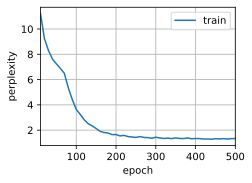

In [10]:
# 使用高级API训练模型
# 设置训练的迭代周期数和学习率
num_epochs, lr = 500, 1
# 使用高级API训练模型，传入模型、训练数据迭代器、词汇表、学习率和迭代周期数进行训练
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)